In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)


In [2]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((54315, 59), (9586, 59), (54315, 1), (9586, 1))

In [3]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'valor_prestamo_x_impulsividad_entre_cuentas_otros', 
 'valor_prestamo_x_confianza_entre_cuentas_otros',
 'saldo_cuenta_x_confianza_entre_tiempo_empleo', 
 'autocontrol_x_confianza', 
 'impulsividad_x_confianza',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_confianza_entre_cuentas_otros,saldo_cuenta_x_confianza_entre_tiempo_empleo,autocontrol_x_confianza,impulsividad_x_confianza,Autocontrol,Impulsividad,Confianza,target
valor_prestamo_x_impulsividad_entre_cuentas_otros,1.00000,0.92748,0.00139,0.00635,0.13367,0.00822,0.18930,0.00073,-0.00175
valor_prestamo_x_confianza_entre_cuentas_otros,0.92748,1.00000,0.00612,0.13648,0.13321,0.00792,0.00182,0.18791,-0.00185
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.00139,0.00612,1.00000,0.02300,0.01920,0.00749,0.00145,0.02488,-0.00394
autocontrol_x_confianza,0.00635,0.13648,0.02300,1.00000,0.49199,0.70467,0.00296,0.69984,-0.00248
impulsividad_x_confianza,0.13367,0.13321,0.01920,0.49199,1.00000,0.00897,0.70017,0.69816,-0.00274
Autocontrol,0.00822,0.00792,0.00749,0.70467,0.00897,1.00000,0.00585,0.00627,-0.00449
Impulsividad,0.18930,0.00182,0.00145,0.00296,0.70017,0.00585,1.00000,-0.00233,-0.00322
Confianza,0.00073,0.18791,0.02488,0.69984,0.69816,0.00627,-0.00233,1.00000,-0.00062
target,-0.00175,-0.00185,-0.00394,-0.00248,-0.00274,-0.00449,-0.00322,-0.00062,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Autocontrol,0.00449
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.00394
Impulsividad,0.00322
impulsividad_x_confianza,0.00274
autocontrol_x_confianza,0.00248
valor_prestamo_x_confianza_entre_cuentas_otros,0.00185
valor_prestamo_x_impulsividad_entre_cuentas_otros,0.00175
Confianza,0.00062


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_confianza_entre_cuentas_otros,saldo_cuenta_x_confianza_entre_tiempo_empleo,autocontrol_x_confianza,impulsividad_x_confianza,Autocontrol,Impulsividad,Confianza,target
valor_prestamo_x_impulsividad_entre_cuentas_otros,1.00000,0.96648,0.00434,0.00583,0.09213,0.00936,0.13123,0.00103,-0.00118
valor_prestamo_x_confianza_entre_cuentas_otros,0.96648,1.00000,0.01277,0.09535,0.09165,0.00881,0.00310,0.12916,-0.00104
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.00434,0.01277,1.00000,0.04537,0.04459,0.00136,0.00007,0.06187,-0.00354
autocontrol_x_confianza,0.00583,0.09535,0.04537,1.00000,0.48264,0.69262,0.00441,0.68471,-0.00423
impulsividad_x_confianza,0.09213,0.09165,0.04459,0.48264,1.00000,0.01129,0.68763,0.68401,-0.00223
Autocontrol,0.00936,0.00881,0.00136,0.69262,0.01129,1.00000,0.00551,0.00627,-0.00370
Impulsividad,0.13123,0.00310,0.00007,0.00441,0.68763,0.00551,1.00000,-0.00156,-0.00377
Confianza,0.00103,0.12916,0.06187,0.68471,0.68401,0.00627,-0.00156,1.00000,-0.00111
target,-0.00118,-0.00104,-0.00354,-0.00423,-0.00223,-0.00370,-0.00377,-0.00111,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
autocontrol_x_confianza,0.00423
Impulsividad,0.00377
Autocontrol,0.00370
saldo_cuenta_x_confianza_entre_tiempo_empleo,0.00354
impulsividad_x_confianza,0.00223
valor_prestamo_x_impulsividad_entre_cuentas_otros,0.00118
Confianza,0.00111
valor_prestamo_x_confianza_entre_cuentas_otros,0.00104


In [9]:
del x_train['target']

In [10]:
import statsmodels.api as sm

logit_model_2 = sm.Logit(y_train , x_train[cols_aporte])
result_2 = logit_model_2.fit()

Optimization terminated successfully.
         Current function value: 0.407139
         Iterations 6


In [11]:
calcular_pesos(result_2)

valor_prestamo_x_impulsividad_entre_cuentas_otros     0.033243
valor_prestamo_x_confianza_entre_cuentas_otros        0.050183
saldo_cuenta_x_confianza_entre_tiempo_empleo          0.146708
impulsividad_x_confianza                              2.005306
Impulsividad                                          2.437555
autocontrol_x_confianza                               6.838120
Autocontrol                                           7.891878
Confianza                                            80.597006
Name: pesos, dtype: float64

In [12]:
result_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: Logit
==================================================================================================
Model:                         Logit                       Pseudo R-squared:            -0.000    
Dependent Variable:            Incumplimiento              AIC:                         44243.5255
Date:                          2021-06-07 19:23            BIC:                         44314.7459
No. Observations:              54315                       Log-Likelihood:              -22114.   
Df Model:                      7                           LL-Null:                     -22109.   
Df Residuals:                  54307                       LLR p-value:                 1.0000    
Converged:                     1.0000                      Scale:                       1.0000    
No. Iterations:                6.0000                                                             
--------------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------
valor_prestamo_x_impulsividad_entre_cuentas_otros  0.1077   0.2433   0.4428 0.6579 -0.3690  0.5845
valor_prestamo_x_confianza_entre_cuentas_otros    -0.1550   0.2848  -0.5441 0.5864 -0.7133  0.4033
saldo_cuenta_x_confianza_entre_tiempo_empleo      -1.6421   1.7651  -0.9303 0.3522 -5.1017  1.8175
autocontrol_x_confianza                            3.2293   0.5084   6.3513 0.0000  2.2328  4.2258
impulsividad_x_confianza                           1.7795   0.5174   3.4394 0.0006  0.7654  2.7935
Autocontrol                                       -2.5096   0.3678  -6.8232 0.0000 -3.2305 -1.7887
Impulsividad                                      -1.3973   0.3685  -3.7921 0.0001 -2.1195 -0.6751
Confianza                                         -3.7258   0.1709 -21.8050 0.0000 -4.0607 -3.3909
==================================================================================================

"""

In [13]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict(x_train[cols_aporte])
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict(x_valid[cols_aporte])
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [14]:
pd.Series(y_pred_class_2_train).value_counts()

0    54315
dtype: int64

In [15]:
pd.Series(y_pred_class_2_valid).value_counts()

0    9586
dtype: int64

<AxesSubplot:>

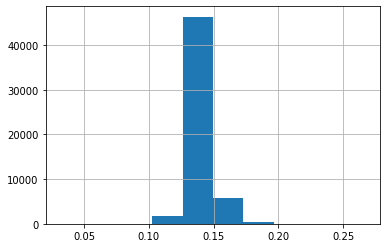

In [16]:
y_pred_prob_2_train.hist()

<AxesSubplot:>

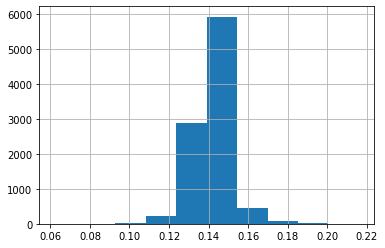

In [17]:
y_pred_prob_2_valid.hist()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.508
GINI: 0.016
///////////////////////// VALIDATION
AUC: 0.497
GINI: -0.005


In [19]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### >>> RECALL

In [20]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 7
 success: True
       x: array([0.01298791])

In [21]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.012987907660010789

In [22]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [23]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    54315
dtype: int64

In [24]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    9586
dtype: int64

In [25]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14115806
F1 SCORE   : 0.24739440
///////////////////////// VALIDATION
RECALL     : 1.00000000
EFECTIVIDAD: 0.14114333
F1 SCORE   : 0.24737179


#### >>> EFECTIVIDAD

In [26]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     fun: -0.25
 message: 'Optimization terminated successfully.'
    nfev: 152
     nit: 9
 success: True
       x: array([0.23116881])

#### >>> AUC

In [27]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.5009804048321894
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.12192201])

In [28]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.12192200646606993

In [29]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [30]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.98369636
EFECTIVIDAD: 0.14140013
F1 SCORE   : 0.24725842
///////////////////////// VALIDATION
RECALL     : 0.98152254
EFECTIVIDAD: 0.14138188
F1 SCORE   : 0.24716173
